In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


In [2]:
import os

In [3]:
data_path = '../data/raw/etl_952_singlechar_size_64/952_labels.txt'

In [4]:
df = pd.read_csv(data_path, delim_whitespace=True, header=None, names=['label', 'character', 'JISx0208', 'UTF8', 'Cangjie'])

FileNotFoundError: [Errno 2] No such file or directory: '../data/raw/etl_952_singlechar_size_64/952_labels.txt'

In [5]:
df = df.drop(0)
cols = df.columns.tolist()
cols.append(cols.pop(cols.index('label')))
df = df[cols]

In [6]:
df

,character,JISx0208,UTF8,Cangjie,label
1,あ,0x2422,u'\u3042',zc,0
2,い,0x2424,u'\u3044',zc,1
3,う,0x2426,u'\u3046',zc,2
4,え,0x2428,u'\u3048',zc,3
5,お,0x242A,u'\u304a',zc,4
...,...,...,...,...,...
948,欲,0x4D5F,u'\u6b32',crno,947
949,立,0x4E29,u'\u7acb',yt,948
950,力,0x4E4F,u'\u529b',ks,949
951,歴,0x4E72,u'\u6b74',mddm,950


In [7]:
df.describe()

,character,JISx0208,UTF8,Cangjie,label
count,952,952,952,952,952
unique,952,952,952,882,952
top,あ,0x2422,u'\u3042',zc,0
freq,1,1,1,71,1


In [8]:
df['Cangjie'].value_counts()

Cangjie
zc      71
tbc      1
fji      1
ifbm     1
taj      1
        ..
kdog     1
mnij     1
ylb      1
vif      1
hdr      1
Name: count, Length: 882, dtype: int64

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [10]:
train_path = '../data/raw/etl_952_singlechar_size_64/952_train'
val_path = '../data/raw/etl_952_singlechar_size_64/952_val'
test_path = '../data/raw/etl_952_singlechar_size_64/952_test'

In [11]:
tmp_img = ''
for labels in os.listdir(train_path):
    print(str(labels))
    print(len(os.listdir(os.path.join(train_path, labels))))
    for img in os.listdir(os.path.join(train_path, labels)):
        img_path = os.path.join(train_path, labels, img)
        image = Image.open(img_path)
        print(image.mode)
        tmp_img = image
        break
    break


0
158
L


In [12]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize grayscale images
])

In [13]:
tmp_tensor = transform(tmp_img)
type(tmp_tensor)

torch.Tensor

In [14]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label in range(len(os.listdir(root_dir))): 
            folder_path = os.path.join(root_dir, str(label))
            for image_name in os.listdir(folder_path):
                if image_name.endswith('.png'):
                    self.image_paths.append(os.path.join(folder_path, image_name))
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)  
        image = image.convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

train_dataset = CustomImageDataset(train_path, transform=transform)
val_dataset = CustomImageDataset(val_path, transform=transform)
test_dataset = CustomImageDataset(test_path, transform=transform)

In [15]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

150915
21980
16236


In [16]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [17]:
train_subset = torch.utils.data.Subset(train_dataset, range(0, 1000))
subset_loader = DataLoader(train_subset, batch_size=4, shuffle=True)

In [18]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 952)  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

c:\Program Files\Python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Program Files\Python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
import torch
from tqdm import tqdm
import time

def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    model.train()
    return accuracy


def train(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    model.train()
    train_loss = []
    train_acc = []
    val_acc = []
    steps = 0
    log_interval = 2000

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        start_time = time.time()

        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}") as pbar:
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                steps += 1
                if steps % log_interval == 0:
                    train_accuracy = 100 * correct / total
                    val_accuracy = evaluate(model, val_loader, device)
                    print(f"Step {steps}, Epoch {epoch+1}/{epochs}, Loss: {running_loss / steps:.4f}, "
                          f"Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")

                pbar.update(1)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        val_accuracy = evaluate(model, val_loader, device)
        val_acc.append(val_accuracy)
        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%, "
              f"Val Accuracy: {val_accuracy:.2f}%, Time: {epoch_time:.2f}s")

    return train_loss, train_acc, val_acc


In [20]:
train_loss, train_acc, val_acc = train(model, train_loader, val_loader, criterion, optimizer, epochs=2, device = device)

# Evaluate on the test set


Epoch 1/2:  11%|█         | 2002/18865 [03:14<18:46:25,  4.01s/it]

Step 2000, Epoch 1/2, Loss: 4.8013, Train Accuracy: 22.19%, Val Accuracy: 67.53%


Epoch 1/2:  21%|██        | 4002/18865 [06:10<11:54:19,  2.88s/it]

Step 4000, Epoch 1/2, Loss: 3.0751, Train Accuracy: 49.13%, Val Accuracy: 93.91%


Epoch 1/2:  32%|███▏      | 6002/18865 [09:06<10:28:37,  2.93s/it]

Step 6000, Epoch 1/2, Loss: 2.2101, Train Accuracy: 63.18%, Val Accuracy: 96.50%


Epoch 1/2:  42%|████▏     | 8002/18865 [12:06<10:37:15,  3.52s/it]

Step 8000, Epoch 1/2, Loss: 1.7334, Train Accuracy: 70.84%, Val Accuracy: 97.50%


Epoch 1/2:  53%|█████▎    | 10002/18865 [15:18<7:56:33,  3.23s/it] 

Step 10000, Epoch 1/2, Loss: 1.4298, Train Accuracy: 75.72%, Val Accuracy: 98.00%


Epoch 1/2:  64%|██████▎   | 12002/18865 [18:32<6:13:02,  3.26s/it]

Step 12000, Epoch 1/2, Loss: 1.2214, Train Accuracy: 79.08%, Val Accuracy: 98.28%


Epoch 1/2:  74%|███████▍  | 14002/18865 [21:25<4:22:46,  3.24s/it]

Step 14000, Epoch 1/2, Loss: 1.0684, Train Accuracy: 81.55%, Val Accuracy: 98.05%


Epoch 1/2:  85%|████████▍ | 16002/18865 [24:14<2:16:51,  2.87s/it]

Step 16000, Epoch 1/2, Loss: 0.9520, Train Accuracy: 83.44%, Val Accuracy: 98.31%


Epoch 1/2:  95%|█████████▌| 18002/18865 [27:18<59:26,  4.13s/it]  

Step 18000, Epoch 1/2, Loss: 0.8601, Train Accuracy: 84.93%, Val Accuracy: 98.51%


Epoch 1/2: 100%|██████████| 18865/18865 [28:23<00:00, 11.07it/s]


Epoch 1/2, Loss: 0.8255, Train Accuracy: 85.51%, Val Accuracy: 98.21%, Time: 1732.95s


Epoch 2/2:   6%|▌         | 1138/18865 [01:02<8:37:51,  1.75s/it] 

Step 20000, Epoch 2/2, Loss: 0.0049, Train Accuracy: 97.91%, Val Accuracy: 98.50%


Epoch 2/2:  17%|█▋        | 3139/18865 [02:47<9:43:12,  2.23s/it] 

Step 22000, Epoch 2/2, Loss: 0.0132, Train Accuracy: 97.57%, Val Accuracy: 98.62%


Epoch 2/2:  27%|██▋       | 5139/18865 [04:20<7:28:53,  1.96s/it] 

Step 24000, Epoch 2/2, Loss: 0.0194, Train Accuracy: 97.64%, Val Accuracy: 98.61%


Epoch 2/2:  38%|███▊      | 7139/18865 [05:49<4:56:27,  1.52s/it]

Step 26000, Epoch 2/2, Loss: 0.0245, Train Accuracy: 97.66%, Val Accuracy: 98.31%


Epoch 2/2:  48%|████▊     | 9139/18865 [07:20<4:32:08,  1.68s/it]

Step 28000, Epoch 2/2, Loss: 0.0285, Train Accuracy: 97.70%, Val Accuracy: 98.99%


Epoch 2/2:  59%|█████▉    | 11138/18865 [08:52<4:28:14,  2.08s/it]

Step 30000, Epoch 2/2, Loss: 0.0322, Train Accuracy: 97.70%, Val Accuracy: 98.91%


Epoch 2/2:  70%|██████▉   | 13138/18865 [10:24<3:06:30,  1.95s/it]

Step 32000, Epoch 2/2, Loss: 0.0345, Train Accuracy: 97.77%, Val Accuracy: 98.72%


Epoch 2/2:  80%|████████  | 15139/18865 [11:57<1:50:20,  1.78s/it]

Step 34000, Epoch 2/2, Loss: 0.0376, Train Accuracy: 97.76%, Val Accuracy: 98.79%


Epoch 2/2:  91%|█████████ | 17139/18865 [13:27<47:02,  1.64s/it]  

Step 36000, Epoch 2/2, Loss: 0.0393, Train Accuracy: 97.82%, Val Accuracy: 98.89%


Epoch 2/2: 100%|██████████| 18865/18865 [14:20<00:00, 21.91it/s]


Epoch 2/2, Loss: 0.0816, Train Accuracy: 97.85%, Val Accuracy: 99.20%, Time: 890.46s


TypeError: evaluate() missing 1 required positional argument: 'device'

In [22]:
test_accuracy = evaluate(model, test_loader, device)
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 99.25%


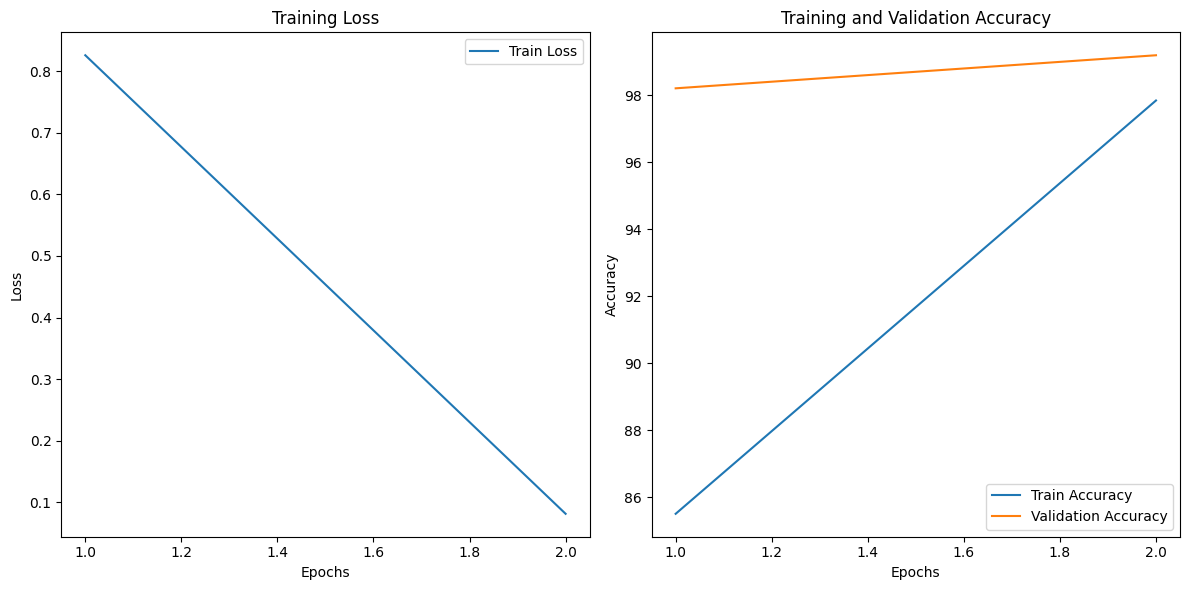

In [24]:
epochs_range = range(1, 3)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
torch.save(model, 'resnet18_etl_952_singlechar_size_64.pth')